In [83]:
import pandas as pd
from pathlib import Path
import subprocess
import re

In [84]:
ROOT = Path("../")
LOG_PATH = ROOT / "batch" / "target-files.log"
YEAR_PAGE_RE = re.compile(r"(18|19|20)\d{2}-(\d{4})")
TARGET_PATH = "/Users/renyi/Downloads/rosenwald/annoter-pipeline/double-triangle-annotation/reviewer-triangle/aligned-split-cleaned"

In [85]:
# list all the jsons under TARGET_PATH
target_files = list(Path(TARGET_PATH).rglob("*.json"))

In [86]:
pairs = set()
for target_file in target_files:
    line = str(target_file).strip()
    if not line:
        continue

    # Find the last year-page occurrence in the line
    year_page_matches = list(YEAR_PAGE_RE.finditer(line))
    if not year_page_matches:
        continue
    year_match = year_page_matches[-1]
    year = year_match.group(0).split("-")[0]
    page = year_match.group(0).split("-")[1]

    pairs.add((year, page))

sorted_pairs = sorted(pairs, key=lambda t: (int(t[0]), int(t[1])))


In [87]:
len(sorted_pairs)

31

In [88]:
# run python pdf2png.py <year> --page <page> for each pair
for year, page in sorted_pairs:
    # check if the image already exists
    image_path = ROOT / "rosenwald-images" / year / f"{year}-page-{page}.png"
    if image_path.exists():
        continue
    if year == "2025":
        continue
    subprocess.run(["python3", "../pdf2png.py", year, "--page", page])

In [89]:
# Run tesseract
def extract_text(img_path, output_path):
    language = 'fra'
    psm = '3' # Page segmentation mode (default: 3 for automatic page segmentation)
    cmd = [
        'tesseract', str(img_path), str(output_path.with_suffix('')),
        '-l', language, '--psm', psm
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✓ Success: {output_path}")
        return True
    else:
        print(f"✗ Failed: {img_path.name}")
        print(f"  Error: {result.stderr.strip()}")
        return False

In [90]:
for year, page in sorted_pairs:
    img_path = ROOT / "rosenwald-images" / year / f"{year}-page-{page}.png"
    output_path = ROOT / "rosenwald-tesseract-ocr" / year / f"{year}-page-{page}.txt"
    # if output_path exists, skip
    if output_path.exists():
        continue
    output_path.parent.mkdir(parents=True, exist_ok=True)
    extract_text(img_path, output_path)

In [91]:
original_text_dict = {}
for year, page in sorted_pairs:
    if year == "2025":
        continue
    file_path = ROOT / "rosenwald-original-ocr" / year / f"{year}-page-{page}.txt"
    text = file_path.read_text(encoding="utf-8")
    original_text_dict[(year, page)] = text

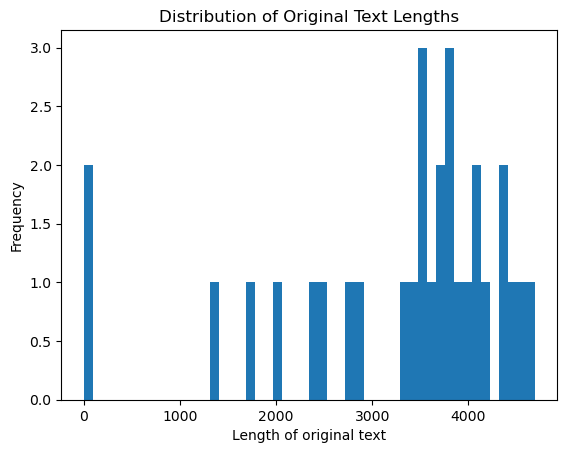

In [92]:
# length distribution of original texts in histogram, labelled with year and page
lengths = [len(text) for text in original_text_dict.values()]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Length of original text")
plt.ylabel("Frequency")
plt.title("Distribution of Original Text Lengths")
plt.show()


In [93]:
# filter out the years and pages with original text length < 3000
filtered_pairs = {(year, page) : text for (year, page), text in original_text_dict.items() if len(text) < 3000 and len(text) > 0}
len(filtered_pairs)

7

In [94]:
filtered_pairs.keys()

dict_keys([('1887', '0198'), ('1888', '0096'), ('1890', '0371'), ('1891', '0096'), ('1893', '0061'), ('1895', '0109'), ('1897', '0124')])

In [95]:
zero_length_pairs = [(year, page) for (year, page), text in original_text_dict.items() if len(text) == 0]

In [96]:
zero_length_pairs

[('1899', '0287'), ('1903', '0532')]

In [97]:
tesseract_text_dict = {}
for year, page in sorted_pairs:
    file_path = ROOT / "rosenwald-tesseract-ocr" / year / f"{year}-page-{page}.txt"
    text = file_path.read_text(encoding="utf-8")
    tesseract_text_dict[(year, page)] = text


In [98]:
len(tesseract_text_dict), len(original_text_dict)

(31, 30)

In [99]:
original_text_dict[('2025', '0101')] = tesseract_text_dict[('2025', '0101')]
for year, page in zero_length_pairs:
    original_text_dict[(year, page)] = tesseract_text_dict[(year, page)]

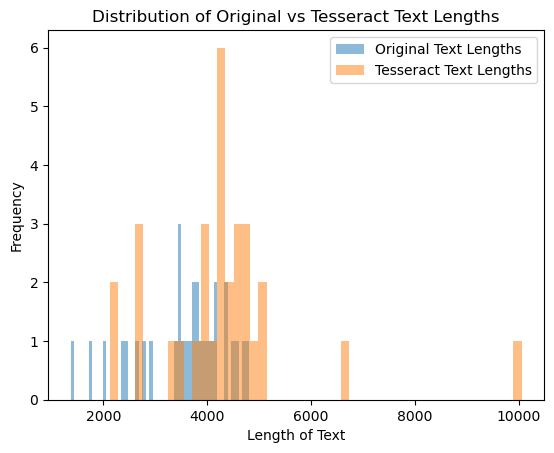

In [100]:
# draw the histogram of original text lengths and tesseract text lengths
original_lengths = [len(text) for text in original_text_dict.values()]
tesseract_lengths = [len(tesseract_text_dict[key]) for key in original_text_dict.keys()]
plt.hist(original_lengths, bins=50, alpha=0.5, label='Original Text Lengths')
plt.hist(tesseract_lengths, bins=50, alpha=0.5, label='Tesseract Text Lengths')
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.title("Distribution of Original vs Tesseract Text Lengths")
plt.legend()
plt.show()

In [101]:
extra_long_pairs = [(year, page) for (year, page), text in tesseract_text_dict.items() if len(text) > 6000]
extra_long_pairs

[('1896', '0380'), ('1904', '0514')]

In [102]:
original_text_dict.keys()

dict_keys([('1887', '0029'), ('1887', '0032'), ('1887', '0198'), ('1888', '0064'), ('1888', '0096'), ('1888', '0296'), ('1890', '0305'), ('1890', '0371'), ('1891', '0096'), ('1892', '0088'), ('1892', '0320'), ('1893', '0061'), ('1895', '0109'), ('1895', '0431'), ('1896', '0380'), ('1897', '0124'), ('1897', '0292'), ('1897', '0421'), ('1898', '0325'), ('1898', '0431'), ('1899', '0287'), ('1901', '0341'), ('1903', '0532'), ('1904', '0156'), ('1904', '0514'), ('1905', '0425'), ('1905', '0452'), ('1905', '0508'), ('1906', '0171'), ('1906', '0501'), ('2025', '0101')])

In [103]:
import csv

def escape_text(text):
    if text is None:
        return ""
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = text.replace("\n", r"\n")
    text = text.replace("\t", r"\t")  # optional but recommended for strict TSV
    return text

def write_tsv(path, text_dict):
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["year", "page", "text"])
        for (year, page) in sorted_pairs:
            w.writerow([year, page, escape_text(text_dict[(year, page)])])

write_tsv("rosenwald-benchmark-original.tsv", original_text_dict)
write_tsv("rosenwald-benchmark-tesseract.tsv", tesseract_text_dict)